In [1]:
#This notebook is where we will test our code. We may convert all code to a .py file if necessary
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# global variables
BOARD_ROWS = 5
BOARD_COLS = 5
WIN_STATE = (1, 3)
LOSE_STATE = (4, 2)
START = (2, 0)
DETERMINISTIC = True

In [2]:

class State:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC

    def giveReward(self):
        if self.state == WIN_STATE:
            return 50
        elif self.state == LOSE_STATE:
            return -50
        else:
            return 0

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):
            self.isEnd = True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position
        """
        if self.determine:
            if action == "up":
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == "down":
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == "left":
                nxtState = (self.state[0], self.state[1] - 1)
            else:
                nxtState = (self.state[0], self.state[1] + 1)
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (BOARD_ROWS -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (BOARD_COLS -1)):
                    if nxtState != (1, 1):
                        return nxtState
            return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')


In [45]:

# Agent of player

class Agent:

    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2
        self.exp_rate = 0.3

        # initial state reward
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0  # set initial value to 0

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                # if the action is deterministic
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()

    def play(self, rounds=10):
        i = 0
        steps = 0
        self.step_reward_df = pd.DataFrame( columns=['Round','Steps','Reward'])
        df = pd.DataFrame( columns=['Round','Steps','Reward'])
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                # explicitly assign end state to reward values
                self.state_values[self.State.state] = reward  # this is optional
                
                self.step_reward_df.loc[len(self.step_reward_df.index)] = [i, steps, reward] 
                #self.step_reward_df.append(df)
                #print("Game End Reward", reward)
                for s in reversed(self.states):
                    reward = self.state_values[s] + self.lr * (reward - self.state_values[s])
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
                steps = 0
            else:
                steps += 1
                action = self.chooseAction()
                # append trace
                self.states.append(self.State.nxtPosition(action))
                #print("current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                #print("nxt state", self.State.state)
                #print("---------------------")

    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')

In [46]:
if __name__ == "__main__":
    ag = Agent()
    ag.play(1000)
    print(ag.showValues())
    values= ag.state_values
    step_reward_df = ag.step_reward_df
df = pd.DataFrame.from_dict(values, orient='index')
df[['row','column']] = df.index.values.tolist()
df = df.set_index(['row','column'])[0].unstack()
step_reward_df

----------------------------------
| 49.93  | 49.954 | 49.952 | 49.904 | 49.418 | 
----------------------------------
| 49.542 | 0      | 49.778 | 50.0   | 38.706 | 
----------------------------------
| 47.48  | 45.094 | 45.947 | 37.394 | 10.344 | 
----------------------------------
| 43.38  | 40.824 | 36.479 | 23.415 | 2.018  | 
----------------------------------
| 39.314 | 33.341 | -50.0  | 0      | 0      | 
----------------------------------
None


,Round,Steps,Reward
0,0,53,50
1,1,9,50
2,2,7,50
3,3,8,50
4,4,10,50
...,...,...,...
995,995,7,50
996,996,18,50
997,997,6,50
998,998,8,50


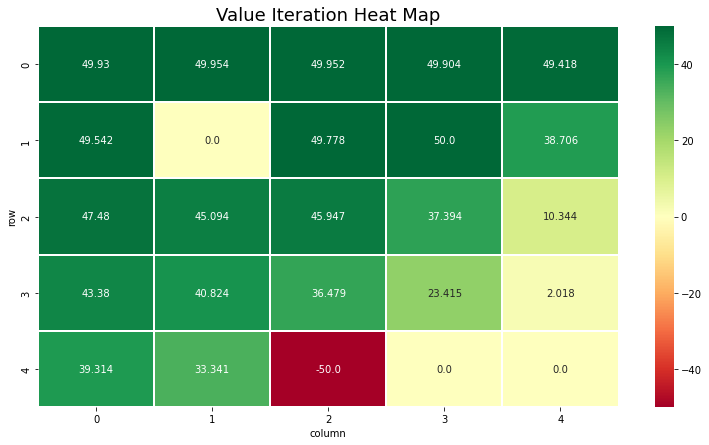

In [47]:
# Define the plot
fig, ax = plt.subplots(figsize=(13,7))
# Add title to the Heat map
title = "Value Iteration Heat Map"
# Set the font size and the distance of the title from the plot
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])


#Create Heatmap in Seaborn
sns.heatmap(df,annot = df,fmt="",cmap='RdYlGn',linewidths=0.30)
# Display the Pharma Sector Heatmap
plt.show()

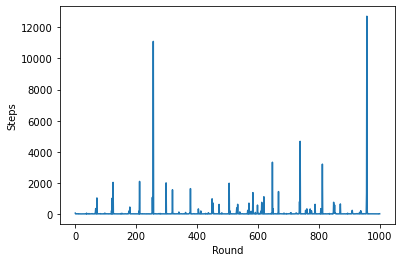

In [48]:
#reward and steps per iteration
sns.lineplot(data=step_reward_df, x="Round", y="Steps")
plt.show()